#MLP Softmax

URL:https://colab.research.google.com/drive/1lQqb_Z5X_7qoLQzP5LlTeh00U8wp9fFg?usp=sharing

In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, f1_score,confusion_matrix,make_scorer,log_loss
from imblearn.over_sampling import SMOTE
from scipy.stats import loguniform
from sklearn.utils import resample
from sklearn.utils.fixes import loguniform
import matplotlib.pyplot as plt
from google.colab import drive

#only for google drive
drive.mount('/content/drive')
path2dataset=  '/content/drive/MyDrive/MIE424 Project - Group C/Dataset'
path2csv = os.path.join(path2dataset,"Date_Fruit_Datasets.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv(path2csv)
#features have different values and ranges, need to normalize as per these statistics
#print(np.around(data.describe().loc[['count','mean','std','min','max']],decimals=2))

#normalize numerical features
data.iloc[:,1:34]=data.iloc[:,1:34].apply(lambda x: (x-np.mean(x))/np.std(x))

#split to X and Y
X=data.iloc[:,1:34]
Y= data["Class"]

#do splits 
#split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=1)
# #split train into train and validation
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=1/9, stratify=Y_train, random_state=1)

In [ ]:
initial_model = MLPClassifier()

# #do grid search to do hyperparameter tuning

dist_grid =dict(hidden_layer_sizes=[(50,100,100,50)],
                alpha=loguniform(1e-7, 5),
                solver=['lbfgs','sgd', 'adam'],
                max_iter=np.linspace(100,100000000,500,dtype="int"), 
                early_stopping=[True,False],
                learning_rate=['constant','invscaling','adaptive'])

#clf = GridSearchCV(initial_model,param_grid=param_grid,scoring='f1_weighted',n_jobs=-1)
clf = RandomizedSearchCV(initial_model,param_distributions = dist_grid, scoring = 'accuracy',n_jobs=-1,n_iter=25)
clf.fit(X_validation,Y_validation)
best_params = clf.best_params_
print(clf.best_params_)
print(clf.best_score_)

hidden_layer_sizes = best_params['hidden_layer_sizes']
alpha = best_params['alpha']
solver = best_params['solver']
max_iter=best_params['max_iter']
early_stopping=best_params['early_stopping']
learning_rate=best_params['learning_rate']

{'alpha': 0.033949965523182496, 'early_stopping': False, 'hidden_layer_sizes': (50, 100, 100, 50), 'learning_rate': 'invscaling', 'max_iter': 30661391, 'solver': 'adam'}
0.9


Output Layer is  softmax
Accuracy is  0.8333333333333334
F1 is  0.7973684210526315


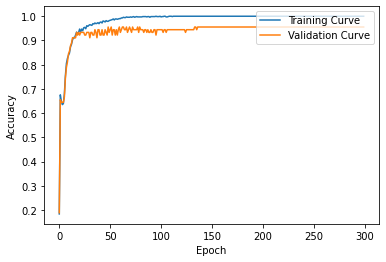

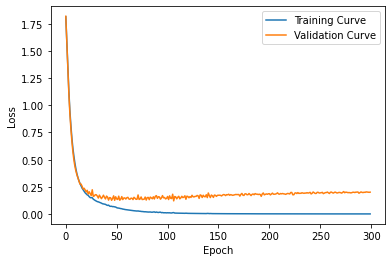

In [ ]:
model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                      alpha=alpha,
                      solver= solver,
                      max_iter=max_iter, 
                      early_stopping=early_stopping,
                      learning_rate=learning_rate
                      )

epochs = 300
batches = 1700


accuracy_train,loss_train, accuracy_test, loss_test = train_curves(X_train,Y_train,X_validation,Y_validation,epochs,batches,model)

#as this is a multiclass classification, the output activation defaults to softmax 
#instead of logistic for binary classification
print("Output Layer is ", model.out_activation_)

print("Accuracy is ",accuracy_score(Y_test,model.predict(X_test)))

print("F1 is ",f1_score(Y_test,model.predict(X_test),average='macro'))

plt.plot(accuracy_train)
plt.plot(accuracy_test)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Curve','Validation Curve'],loc='upper right')
plt.show()

plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Curve','Validation Curve'],loc='upper right')
plt.show()

In [ ]:
def train_curves(X_train,Y_train,X_test,Y_test, epochs, batch_size,model):
  training_samples= X_train.shape[0]
  classes = np.unique(Y_train)
  num_classes = classes.shape[0]
  epoch =0 

  accuracy_train = []
  accuracy_test = []
  loss_train=[]
  loss_test=[]

  while epoch < epochs:

      #get a random permutation of row indices
      indices = np.random.permutation(training_samples)
      batch_index = 0
      while True:
          # iterate through a batch of the permutated indices
          indices = indices[batch_index:batch_index + batch_size]
          model.partial_fit(X_train.iloc[indices], Y_train.iloc[indices], classes=classes)
          batch_index += batch_size

          if batch_index >= training_samples:
              break

      #Accuracy TRAIN
      accuracy_train.append(model.score(X_train, Y_train))

      # Accuracy TEST
      accuracy_test.append(model.score(X_test, Y_test))

      #Loss Train
      loss_train.append(log_loss(Y_train,model.predict_proba(X_train),labels=classes))

      #Loss Test
      loss_test.append(log_loss(Y_test,model.predict_proba(X_test),labels=classes))

      epoch += 1

  return accuracy_train,loss_train, accuracy_test, loss_test